# TP2 : American options

In [6]:
K = 100
T = 1
sigma = 0.3
r = 0.1

Smin = 50
Smax = 250
Sval = 90

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import matplotlib as mpl
import time
import scipy.stats as stats
import pandas as pd
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

mpl.rcParams['figure.dpi'] = 125


import numpy as np

arr1 = np.array([[1], [3], [6]])
arr2 = np.array([1, 4, 5])

result = np.maximum(arr1, arr2[:, np.newaxis])

print(result)


[[1]
 [4]
 [6]]


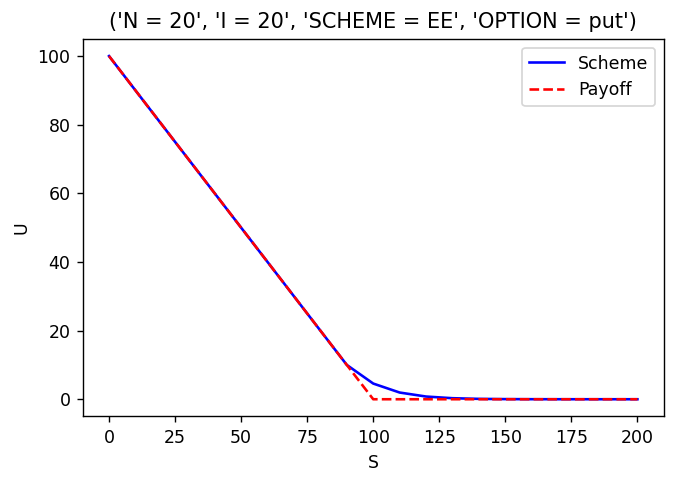

In [7]:
import numpy as np

class SchemePrice:
    def __init__(self, N, I, scheme = "EE", option = "put"):
        self.r = 0.1
        self.sigma = 0.2
        self.payoff = 1
        self.K = 100
        self.T = 1
        self.N = int(N)
        self.I = int(I)
        self.SCHEME = scheme
        self.option = option
        self.Smin = 0
        self.Smax = 200
        self.h = (self.Smax - self.Smin) / self.I
        self.dt = self.T / self.N
        self.S = np.arange(self.Smin, self.Smax + self.h, self.h)
        self.time = np.arange(0, self.T + self.dt, self.dt)
        self.A = self.createA()
        self.U = self.createU()
        self.U0 = self.u0(self.S)
        self.SCHEME = scheme
        self.title = 'N =%3i'%self.N,'I =%3i'%self.I,'SCHEME = %s'%self.SCHEME, 'OPTION = %s'%self.option
        self.mu = (self.dt/self.h**2)*self.sigma**2*self.Smax**2
        self.tcpu = 0
        self.solved = False
                            
    def plot(self):
        self.checkSolved()
        plt.plot(self.S, self.U, color='blue', label='Scheme')
        plt.plot(self.S, self.U0, linestyle="--", color='red', label='Payoff')
        plt.title(self.title)
        plt.xlabel("S")
        plt.ylabel("U")
        plt.legend()
        plt.show()

    def checkSolved(self):
        if not self.solved:
            self.U = self.solve()
    
    def Ind(self, a, b, x):
        return np.where((a <= x) & (x <= b), 1, 0)

    def u0(self, s):
        """
        if self.option == "put":
            return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)
        elif self.option == "call":
            return np.maximum(0, s - self.K) * self.Ind(self.Smin, self.Smax, s)
        """
        if self.payoff == 1:
            return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)

    def uleft(self, t):
        if self.payoff == 1:
            return self.K - self.Smin
        """
        if self.option == "put":
            return self.K * np.exp(-self.r * t) - self.Smin
        elif self.option == "call":
            return 0
        """

    def uright(self, t):
        if self.payoff == 1:
            return 0
        """
        if self.option == "put":
            return 0
        elif self.option == "call":
            return self.Smax - self.K * np.exp(-self.r * t)
        """

    def s(self, j):
        return self.Smin + j * self.h

    def alpha(self, j):
        return self.sigma**2 * self.s(j)**2 / (2 * self.h**2)

    def beta(self, j):
        return self.r * self.s(j) / (2 * self.h)
    
    def interpolate(self, s):
        self.checkSolved()
        s_index = np.argmax(self.S >= s)
        return ((self.S[s_index] - s)/self.h * self.U[s_index-1] + (s - self.S[s_index-1])/self.h * self.U[s_index])[0]

    def createA(self):
        A = np.zeros((self.I + 1, self.I + 1))
        for i in range(self.I + 1):
            alpha = self.alpha(i)
            beta = self.beta(i)
            A[i, i] = 2 * alpha + self.r
            if i > 0:
                A[i, i - 1] = -alpha + beta
            if i < self.I:
                A[i, i + 1] = -alpha - beta
        return A

    def q(self, t):
        y = np.zeros(self.I + 1)
        y[0] = (-self.alpha(0) + self.beta(0)) * self.uleft(t)
        y[-1] = (-self.alpha(self.I) + self.beta(self.I)) * self.uright(t)
        return y.reshape(self.I + 1, 1)

    def createU(self):
        U = np.zeros(self.I + 1)
        U = self.u0(self.S)
        return U.reshape(self.I + 1, 1)
    
    def blackScholes(self, sbar):
        dplus=(np.log(sbar/self.K)+self.r+0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        dmoins=(np.log(sbar/self.K)+self.r-0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        vbar=np.exp(-self.r*self.T)*self.K*stats.norm.cdf(-dmoins)-sbar*stats.norm.cdf(-dplus)
        return vbar

    def solve(self):
        t0 = time.time()
        theta = 0.5 if self.SCHEME == "CR" else 0
        # reverse = self.option == "call"

        if self.payoff == 1:
            for n in range(self.N):
                if self.SCHEME == "EE":
                    self.U = np.maximum(self.U - self.dt * (self.A @ self.U + self.q(self.time[n])), self.U0[:, np.newaxis])
                elif self.SCHEME == "IE":
                    self.U = np.linalg.solve(np.identity(self.I + 1) + self.dt * self.A, -self.dt * self.q(self.time[n]) + self.U)
                elif self.SCHEME == "CR":
                    theta = 0.5
                    F = -(theta * self.q(self.time[n + 1]) + (1 - theta) * self.q(self.time[n]))
                    part1 = self.U - (1 - theta) * self.dt * (self.A @ self.U)
                    self.U = np.linalg.solve(np.identity(self.I + 1) + theta * self.dt * self.A, self.dt * F + part1)
        """elif self.option == "call":
            for n in range(self.N-1, -1, -1):
                if self.SCHEME == "EE":
                    self.U = self.U - self.dt * (self.A @ self.U + self.q(self.time[n]))
                elif self.SCHEME == "IE":
                    self.U = np.linalg.solve(np.identity(self.I + 1) + self.dt * self.A, -self.dt * self.q(self.time[n]) + self.U)
                elif self.SCHEME == "CR":
                    theta = 0.5
                    F = -(theta * self.q(self.time[n + 1]) + (1 - theta) * self.q(self.time[n]))
                    part1 = self.U - (1 - theta) * self.dt * (self.A @ self.U)
                    self.U = np.linalg.solve(np.identity(self.I + 1) + theta * self.dt * self.A, self.dt * F + part1)"""

        self.tcpu = time.time() - t0
        self.solved = True
        return self.U

    
def stabilityTable(scheme, s, Ns, Is, pricer = SchemePrice):

    Us = []
    tcpus = []
    hs = []

    for I in Is:
        N = I
        ee = pricer(N, I, scheme)
        U = ee.interpolate(s)
        Us.append(U)
        hs.append(ee.h)
        tcpus.append(ee.tcpu)


    df = pd.DataFrame({'I': Is, 'N': Ns, 'U(s)': Us})
    df['error'] = np.abs(df['U(s)'].shift() - df['U(s)'])
    df['h'] = hs
    df['alpha'] = np.log(df['error'].shift()/df['error'])/np.log(df['h'].shift()/df['h'])
    df['errex'] = np.abs(df['U(s)'] - ee.blackScholes(s))
    df['alphax'] = np.log(df['errex'].shift()/df['errex'])/np.log(df['h'].shift()/df['h'])

    df['tcpu'] = tcpus
    df = df.drop('h', axis=1)

    return df

SchemePrice(20, 20, "EE").plot()